# Follow-up Tests and Visualisations

## The Need for Follow-up Tests
... For instance, once the data have been suitably wrangled, the typical sequence for any linear model is: 

1. Fit the model using `lm()`
2. Checked and deal with all the assumptions to our satisfaction
3. Call `summary()` on the model and interpret the output 
4. If appropriate, call `Anova()` on the model and interpret the output

As an example, we will use the same full-factorial model of `mtcars` from last week. However, we will increase the complexity by including the `origin` variable with *three* levels (`Japan`, `USA` and `Europe`). So, we now have a $2 \times 3$ ANOVA model and our means table is

(INSERT TABLE HERE)

To make this example more useful, we will also engineer a fake interaction again by increasing the value of MPG for the `(Japan, V-Shaped)` cell alone. The code is in the drop-down below, if you are interested.

In [1]:
data(mtcars)
suppressMessages(library(car))

# Origin factor
mtcars$origin <- c('Japan','Japan','USA','USA','USA','USA','USA','Europe','Europe',
                   'Europe','Europe','Europe','Europe','Europe','USA','USA','USA',
                   'Europe','Japan','Japan','Japan','USA','USA','USA','USA',
                   'Europe','Europe','Europe','USA','Europe','Europe','Europe')
mtcars$origin <- as.factor(mtcars$origin)

# VS factor
vs.lab <- rep("",length(mtcars$vs)) 
vs.lab[mtcars$vs == 0] <- "V-shaped"
vs.lab[mtcars$vs == 1] <- "Straight"
mtcars$vs <- as.factor(vs.lab)

# Create fake interaction
mpg.fake          <- mtcars$mpg                                         # copy mpg
mpg.idx           <- mtcars$origin == "Japan" & mtcars$vs == "V-shaped" # index of Japan-VShaped cell
mpg.fake[mpg.idx] <- mpg.fake[mpg.idx] + 15                             # add 16 to all data from that cell
mtcars$mpg.fake   <- mpg.fake   

The modelling steps are illustrated below. Although somewhat simplified, the overall structure of any analysis will fit this template. So, despite everything we have covered on this unit, this type of analysis largely boils-down to 4 lines of code.


Call:
lm(formula = mpg.fake ~ origin + vs + origin:vs, data = mtcars)

Residuals:
   Min     1Q Median     3Q    Max 
-7.100 -2.766 -0.025  1.858  7.938 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             24.4625     1.4671  16.674 2.11e-15 ***
originJapan              4.1375     2.8093   1.473  0.15281    
originUSA               -3.6958     2.8093  -1.316  0.19980    
vsV-shaped              -6.1958     2.2411  -2.765  0.01034 *  
originJapan:vsV-shaped  13.5958     4.4013   3.089  0.00474 ** 
originUSA:vsV-shaped     0.1792     3.5333   0.051  0.95995    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.15 on 26 degrees of freedom
Multiple R-squared:  0.7206,	Adjusted R-squared:  0.6669 
F-statistic: 13.41 on 5 and 26 DF,  p-value: 1.629e-06

Anova Table (Type II tests)

Response: mpg.fake
          Sum Sq Df F value    Pr(>F)    
origin    663.27  2 19.2594 7.391e-06 ***
vs         99

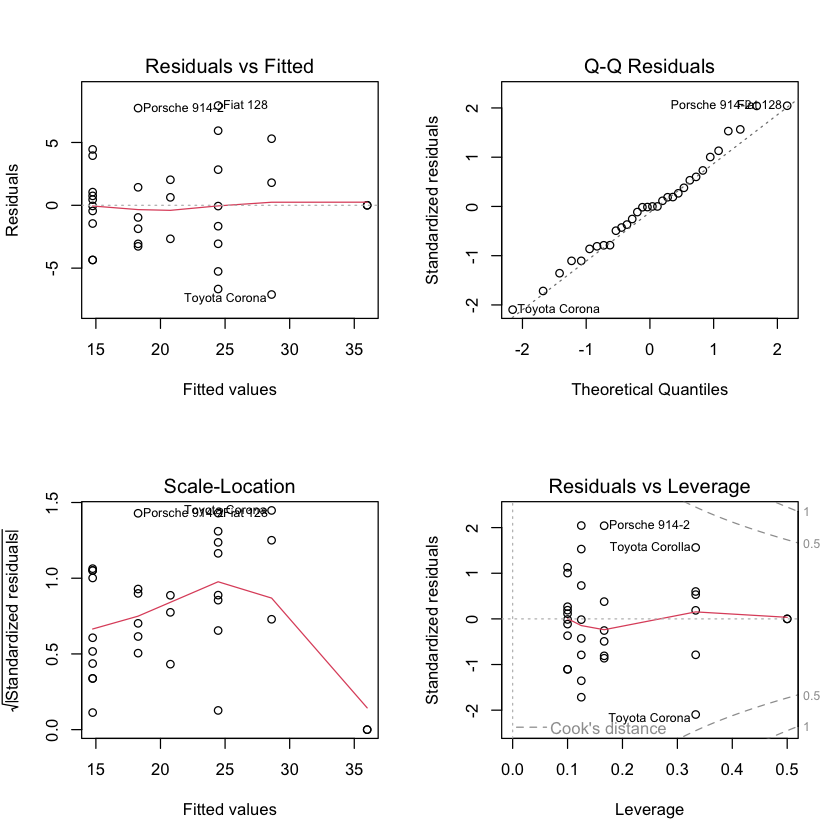

In [2]:
# 1. Fit full factorial model
mod <- lm(mpg.fake ~ origin + vs + origin:vs, data=mtcars)

# 2. Check assumptions
par(mfrow=c(2,2)); plot(mod)

# 3. Call summary() on the final model
print(summary(mod))

# 4. Generate ANOVA table
print(Anova(mod))

Based on this output, what can we conclude? Looking at the ANOVA table, we can see a significant omnibus interaction effect ($F_{2,26} = 5.27, p < 0.05$), meaning we need to ignore the main effects and just work on understanding the interaction. Conceptually, we can think of this effect as indicating that the difference in MPG between `Straight` and `V-Shaped` depends upon whether the car came from `Japan`, `USA` or `Europe`. Alternatively, we can think of this effect as indicating that the differences in MPG betwee `Japan`, `USA` and `Europe` depends upon whether the engine is `Straight` or `V-Shaped`. For most problems, there is usually one way of conceptualising the interaction that is more intuitive or useful than the other. For this example, we will focus on differences in *shape* across the different countries[^context-foot].

So, we are now at the same point that we ended on last week. However, it seems we still have some unanswered questions. Because the interaction is an *omnibus* test, it does not tell us *which* differences are driving the effect. We can conclude that the country of origin appears to change how MPG differs between the two engine shapes, but surely we want to know *how* this change actually occurs? Which countries show the largest difference between engine shapes? Are there any countries where the engine shape makes little difference to MPG? Is this effect driven only by one country or are there multiple countries?

We could get some of the way towards answering these questions by simply *plotting* the effects. Let us have a look at the interaction using an effects plot

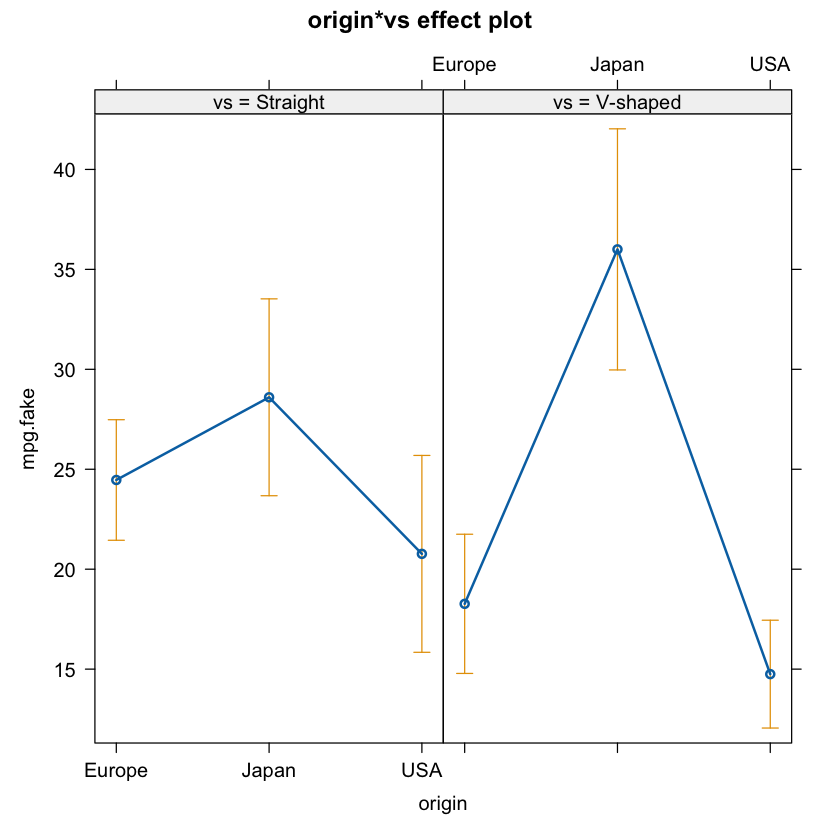

In [3]:
suppressMessages(library(effects))
plot(allEffects(mod))

So, we can clearly see that there is a much larger difference between `Straight` and `V-Shaped` for `Japan` compared to either `Europe` or `USA`. However, we cannot tell whether the differences for either `Europe` or `USA` are significant (by whatever metric you choose), or whether these differences could actually be 0 in the population. This is important because it implies that there is something about Japanese manufacturing and engineering that makes V-shaped engines more efficient[^fake-foot]. However, we cannot tell whether V-shaped engines in `Europe` and `USA` are actually *less efficient*, or have the *same* efficiency as straight engines. So, the plot is useful, but might not give use everything we need. Because of this, we need to dig into the differences we are interested in using *follow-up tests*.

## Using the Regression Tests
One of the most obvious ways we could try to break-down an omnibus ANOVA effect is by returning to the tests of the parameter estimates from the regression model. In simple cases, this is a perfectly fine thing to do. For instance, in a one-way ANOVA, these tests cover all the differences we are interested in (potentially after a few rounds of re-leveling the factor). However, in more complex models, we have already seen how the model parameters do not necessarily correspond to effects we are interested in.

Let us return to $2 \times 3$ model above and examine how the factors are coded.

In [4]:
print(contrasts(mtcars$origin))
print(contrasts(mtcars$vs))

       Japan USA
Europe     0   0
Japan      1   0
USA        0   1
         V-shaped
Straight        0
V-shaped        1


Given this, the full combination of dummy variables in this model would be

In [5]:
X <- matrix(c(0,0,0,
              0,0,1,
              1,0,0,
              1,0,1,
              0,1,0,
              0,1,1), nrow=6, byrow=TRUE)

interact.1 <- X[,1] * X[,3]
interact.2 <- X[,2] * X[,3]

X <- cbind(X,interact.1,interact.2)

rownames(X) <- c("Europe Straight", "Europe V-Shaped",
                  "Japan Straight", "Japan V-Shaped",
                  "USA Straight", "USA V-Shaped")

colnames(X) <- c("Japan", "USA","V-Shaped","Japan:V-Shaped","USA:V-Shaped")
print(X)

                Japan USA V-Shaped Japan:V-Shaped USA:V-Shaped
Europe Straight     0   0        0              0            0
Europe V-Shaped     0   0        1              0            0
Japan Straight      1   0        0              0            0
Japan V-Shaped      1   0        1              1            0
USA Straight        0   1        0              0            0
USA V-Shaped        0   1        1              0            1


Where the final two interaction columns comes from multiplying the columns for `origin` and the columns for `vs`. From here, we can now work out what each parameter in the model means numerically and can decide whether any of these numbers actually answer our questions. If they do, we can use the associated $t$-tests. If they do not, we need to find another approach.

## Using Linear Contrasts

### Simple Main Effects

### The `emmeans` Package

## Multiple Comparisons Correction

### Planned vs Post-hoc Tests
... Beware of this reasoning. Although planned tests are more *credible* in the sense that you are not $p$-hacking, this does not change anything about the error rate. The error does not magically know what your intentions were and then change itself. The error rate is a fact of multiple testing that does not change with intent. As such, even if you have pre-specified tests, you still need to control for multiple comparisons.

## Visualising ANOVA Effects

### Interaction Bar Plots

... If we were interested in the interaction the other way, we could simply swap which factor was displayed on the $x$-axis. For instance ... Visually, this makes the differences of interest more apparent in terms of the bars that are grouped together.

[^context-foot]: If you want more context, imagine you are working for a car manufacturer who is interested in reducing the efficiency gap between straight and V-shaped engines. You have gathered data on these efficiency gaps from various different cars and want to understand how engineering and manufacturing differences across countries contribute.

[^fake-foot]: Remember, these data are *entirely* fabricated. There is not something magical about Japanese cars that makes V-shaped engines super efficient in terms of MPG.